In [1]:
import tifffile as tiff
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2

import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

import torchmetrics

/home/dkermany/.local/share/virtualenvs/BoneSegmentation-C6QGg7XR/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dkermany/.local/share/virtualenvs/BoneSegmentation-C6QGg7XR/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/dkermany/.local/share/virtualenvs/BoneSegmentation-C6QGg7XR/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warn(f"Failed to load image Python extension: {e}")


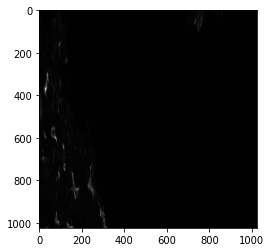

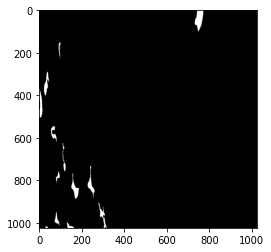

In [2]:
############################################
# Display Image and its corresponding Mask #
############################################
x = mpimg.imread('/home/dkermany/data/Bone_Project/final/Train/Labels/test1_2x3_mask.png',0)
img= cv2.imread('/home/dkermany/data/Bone_Project/final/Train/Images/test1_2x3.png',0)
imgplot = plt.imshow(img, cmap="gray")
plt.show()
imshow(x, cmap='gray')

In [3]:
np.unique(img*255)

array([  0,   4,   8,   9,  10,  13,  14,  15,  16,  19,  20,  22,  23,
        24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  35,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  48,  49,  50,  52,  53,  55,
        56,  57,  58,  60,  61,  62,  63,  64,  65,  66,  67,  68,  71,
        72,  73,  74,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 20

In [4]:
class NucleiDataset(Dataset):
    def __init__(self, image_path, mask_path, transform=None):
        self.img_ls = [image_path+i for i in sorted(os.listdir(image_path))]
        self.mask_ls = [ mask_path+i for i in sorted(os.listdir(mask_path))]
        self.transform = transform

    def __len__(self):
        return len(self.img_ls)

    def __getitem__(self, idx):
        img_name = self.img_ls[idx]
        img = cv2.cvtColor(cv2.imread(img_name, 0), cv2.COLOR_GRAY2RGB)
        mask_name = self.mask_ls[idx]
        mask = cv2.imread(mask_name, 0)
        if self.transform:
            img = self.transform(img)

        return img, mask


trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet normalization
])

label_path = "/home/dkermany/data/Bone_Project/final/Train/Labels/"
img_path = "/home/dkermany/data/Bone_Project/final/Train/Images/"

train_set = NucleiDataset(img_path,label_path, transform = trans)

batch_size = 1  #my gpu is 8gb, using batchsize of 2 already insufficient memory, so i use batch size 1

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)

torch.Size([1, 3, 1024, 1024]) torch.Size([1, 1024, 1024])


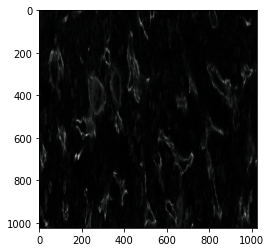

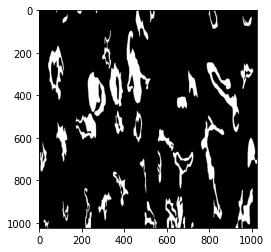

In [5]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp


inputs, masks = next(iter(train_loader))

print(inputs.shape, masks.shape)  #shapes of our inputs to the model and loss function

plt.imshow(reverse_transform(inputs[0]))
plt.show()
imshow(masks[0],cmap='gray')

In [6]:
######################
# Model Architecture #
######################

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [7]:
###################################################################
# Loss function that combines Binary Cross Entropy with Dice loss #
###################################################################

# Model output is (N, 1, 1024,1024), where N = batch size, Thus you will see that i squeeze the 2nd dimension

def weighted_loss(pred,targ,bce_weight=0.5, smooth=1.):
    
    bce = F.binary_cross_entropy_with_logits(pred.squeeze(dim=1), targ)
    
    pred = torch.sigmoid(pred)
    
    pred = pred.contiguous().squeeze(dim=1)  
    targ = targ.contiguous()  

    intersection = (pred * targ).sum(dim=1).sum(dim=1)
    dice = (1 - ((2. * intersection + smooth) / (pred.sum(dim=1).sum(dim=1) + targ.sum(dim=1).sum(dim=1) + smooth)))
    
    loss = bce * bce_weight + dice.mean() * (1 - bce_weight)
    
    return loss

In [8]:
def iou(outputs, labels):
    SMOOTH = 1e-6
    outputs = outputs.squeeze(1)
    
#     print("outputs",torch.unique(outputs))
#     print("labels",torch.unique(labels))
    
    intersection = (outputs & labels).float().sum((1,2))
    union = (outputs | labels).float().sum((1,2))
#     print(intersection, union)
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
#     thresholded = torch.clamp(20. * (iou - 0.5), 0, 10).ceil() / 10.
    
    return iou

In [9]:
def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    
    loss_ls = []
    acc_ls = []
    dice_ls = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()
        
        loss = 0
        acc = 0
        
        for inputs,masks in train_loader:
            model.train()
            inputs = inputs.to(device)
            masks = masks.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            epoch_loss = weighted_loss(outputs,masks,bce_weight=0.3)
            epoch_loss.backward()
            optimizer.step()
            
            n_samples = len(inputs)
            loss+=(epoch_loss/n_samples).item()
            
            outputs_cpu = outputs.detach().to("cpu")[0][0]
            outputs_cpu[outputs_cpu>=0.95] = 1
            outputs_cpu[outputs_cpu<0.95] = 0

            acc += iou(outputs_cpu.int(), masks.int().detach().to('cpu'))

#             outputs = torch.squeeze(torch.argmax(outputs, dim=1))
#             masks = torch.squeeze(masks).int()
#             acc += (outputs == masks).all() / torch.numel(masks)
        
        loss /= len(train_loader)
        acc /= len(train_loader)
        print(f"epoch loss: {loss}, acc: {acc}")
        
        loss_ls.append(loss)
        acc_ls.append(acc)
        
        if (epoch+1)%20==0:
            print("\n","Input Image")
            plt.imshow(reverse_transform(inputs.to('cpu').detach()[0]))
            plt.show()
            print("Predicted Mask Binary")
            threshold=0.95    # vary the threshold
            pred = outputs.to('cpu').detach().numpy()[0][0]
            pred[pred >= threshold] = 1
            pred[pred < threshold] = 0
            plt.imshow(pred,cmap='gray')
            plt.show()
            print("Actual Mask")
            plt.imshow(masks.to('cpu').detach()[0],cmap='gray')
            plt.show()
        
        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60),"\n")
    
    return loss_ls, acc_ls

cuda:0


/home/dkermany/.local/share/virtualenvs/BoneSegmentation-C6QGg7XR/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/dkermany/.local/share/virtualenvs/BoneSegmentation-C6QGg7XR/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/199
----------
epoch loss: 0.5749529172976812, acc: tensor([0.1991])
0m 2s 

Epoch 1/199
----------
epoch loss: 0.30348139703273774, acc: tensor([0.5069])
0m 2s 

Epoch 2/199
----------
epoch loss: 0.24816580911477407, acc: tensor([0.5776])
0m 2s 

Epoch 3/199
----------
epoch loss: 0.22998212178548177, acc: tensor([0.5987])
0m 2s 

Epoch 4/199
----------
epoch loss: 0.25638306339581807, acc: tensor([0.5701])
0m 2s 

Epoch 5/199
----------
epoch loss: 0.23948954542477927, acc: tensor([0.5805])
0m 2s 

Epoch 6/199
----------
epoch loss: 0.23593056599299114, acc: tensor([0.5912])
0m 2s 

Epoch 7/199
----------
epoch loss: 0.2287003815174103, acc: tensor([0.6015])
0m 2s 

Epoch 8/199
----------
epoch loss: 0.20976145068804422, acc: tensor([0.6255])
0m 2s 

Epoch 9/199
----------
epoch loss: 0.20060027639071146, acc: tensor([0.6363])
0m 2s 

Epoch 10/199
----------
epoch loss: 0.1907125582297643, acc: tensor([0.6519])
0m 2s 

Epoch 11/199
----------
epoch loss: 0.19323024948438008,

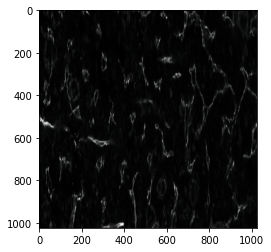

Predicted Mask Binary


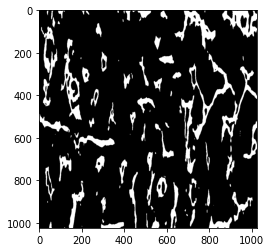

Actual Mask


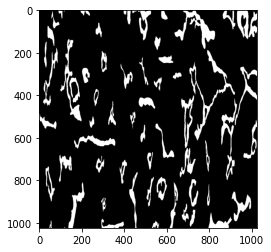

0m 3s 

Epoch 20/199
----------
epoch loss: 0.15195620357990264, acc: tensor([0.7134])
0m 2s 

Epoch 21/199
----------
epoch loss: 0.15350862443447114, acc: tensor([0.7088])
0m 2s 

Epoch 22/199
----------
epoch loss: 0.1643375446399053, acc: tensor([0.6964])
0m 2s 

Epoch 23/199
----------
epoch loss: 0.16494170029958088, acc: tensor([0.6923])
0m 2s 

Epoch 24/199
----------
epoch loss: 0.1522359813253085, acc: tensor([0.7128])
0m 2s 

Epoch 25/199
----------
epoch loss: 0.14312421629826227, acc: tensor([0.7279])
0m 2s 

Epoch 26/199
----------
epoch loss: 0.1435937002301216, acc: tensor([0.7267])
0m 2s 

Epoch 27/199
----------
epoch loss: 0.13628451526165009, acc: tensor([0.7384])
0m 2s 

Epoch 28/199
----------
epoch loss: 0.1359513834118843, acc: tensor([0.7409])
0m 2s 

Epoch 29/199
----------
epoch loss: 0.12950674096743267, acc: tensor([0.7523])
0m 2s 

Epoch 30/199
----------
epoch loss: 0.13111697137355804, acc: tensor([0.7478])
0m 2s 

Epoch 31/199
----------
epoch loss: 0.1

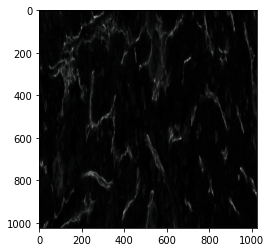

Predicted Mask Binary


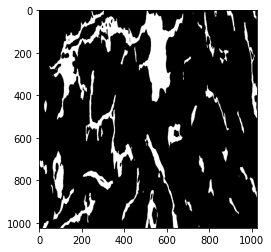

Actual Mask


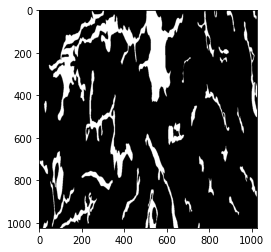

0m 3s 

Epoch 40/199
----------
epoch loss: 0.11277561535437902, acc: tensor([0.7808])
0m 2s 

Epoch 41/199
----------
epoch loss: 0.11592759490013123, acc: tensor([0.7736])
0m 2s 

Epoch 42/199
----------
epoch loss: 0.11190477857987086, acc: tensor([0.7797])
0m 2s 

Epoch 43/199
----------
epoch loss: 0.11274148970842361, acc: tensor([0.7802])
0m 2s 

Epoch 44/199
----------
epoch loss: 0.10534565299749374, acc: tensor([0.7926])
0m 2s 

Epoch 45/199
----------
epoch loss: 0.105628252774477, acc: tensor([0.7924])
0m 2s 

Epoch 46/199
----------
epoch loss: 0.1167944073677063, acc: tensor([0.7732])
0m 2s 

Epoch 47/199
----------
epoch loss: 0.11426330755154292, acc: tensor([0.7758])
0m 2s 

Epoch 48/199
----------
epoch loss: 0.10775024394194285, acc: tensor([0.7898])
0m 2s 

Epoch 49/199
----------
epoch loss: 0.10465003649393717, acc: tensor([0.7924])
0m 2s 

Epoch 50/199
----------
epoch loss: 0.09856647451718649, acc: tensor([0.8044])
0m 2s 

Epoch 51/199
----------
epoch loss: 0.

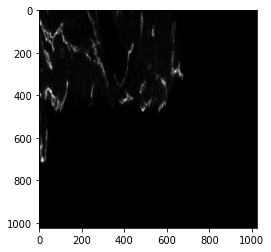

Predicted Mask Binary


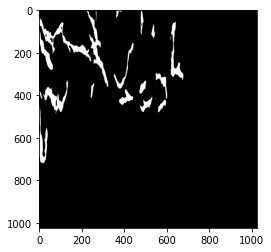

Actual Mask


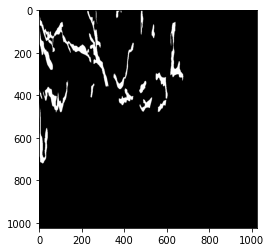

0m 3s 

Epoch 60/199
----------
epoch loss: 0.1027741586168607, acc: tensor([0.7956])
0m 2s 

Epoch 61/199
----------
epoch loss: 0.09149782558282217, acc: tensor([0.8183])
0m 2s 

Epoch 62/199
----------
epoch loss: 0.08934003288547197, acc: tensor([0.8191])
0m 2s 

Epoch 63/199
----------
epoch loss: 0.08587676559885343, acc: tensor([0.8265])
0m 2s 

Epoch 64/199
----------
epoch loss: 0.08329552610715231, acc: tensor([0.8341])
0m 2s 

Epoch 65/199
----------
epoch loss: 0.08149540250500044, acc: tensor([0.8345])
0m 2s 

Epoch 66/199
----------
epoch loss: 0.0794367382923762, acc: tensor([0.8398])
0m 2s 

Epoch 67/199
----------
epoch loss: 0.08207174241542817, acc: tensor([0.8361])
0m 2s 

Epoch 68/199
----------
epoch loss: 0.08060310781002045, acc: tensor([0.8370])
0m 2s 

Epoch 69/199
----------
epoch loss: 0.07557498266299566, acc: tensor([0.8481])
0m 2s 

Epoch 70/199
----------
epoch loss: 0.07777111728986104, acc: tensor([0.8416])
0m 2s 

Epoch 71/199
----------
epoch loss: 0

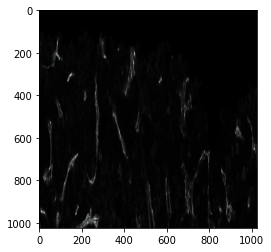

Predicted Mask Binary


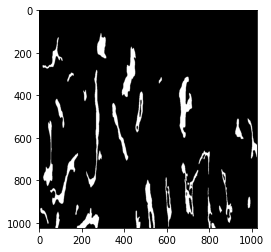

Actual Mask


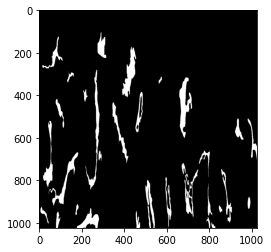

0m 3s 

Epoch 80/199
----------
epoch loss: 0.0696033276617527, acc: tensor([0.8573])
0m 2s 

Epoch 81/199
----------
epoch loss: 0.06675415734450023, acc: tensor([0.8642])
0m 2s 

Epoch 82/199
----------
epoch loss: 0.06292703325549762, acc: tensor([0.8694])
0m 2s 

Epoch 83/199
----------
epoch loss: 0.06769695207476616, acc: tensor([0.8614])
0m 2s 

Epoch 84/199
----------
epoch loss: 0.062616528570652, acc: tensor([0.8716])
0m 2s 

Epoch 85/199
----------
epoch loss: 0.058085379749536516, acc: tensor([0.8802])
0m 2s 

Epoch 86/199
----------
epoch loss: 0.055954032391309735, acc: tensor([0.8844])
0m 2s 

Epoch 87/199
----------
epoch loss: 0.05435486113031705, acc: tensor([0.8878])
0m 2s 

Epoch 88/199
----------
epoch loss: 0.05851030573248863, acc: tensor([0.8802])
0m 2s 

Epoch 89/199
----------
epoch loss: 0.07786680907011032, acc: tensor([0.8401])
0m 2s 

Epoch 90/199
----------
epoch loss: 0.0743978276848793, acc: tensor([0.8494])
0m 2s 

Epoch 91/199
----------
epoch loss: 0

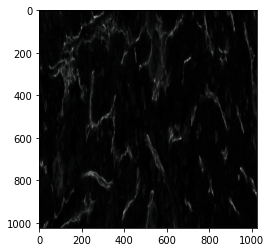

Predicted Mask Binary


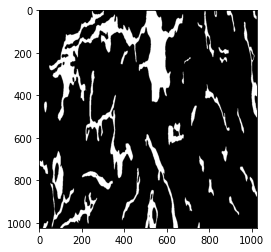

Actual Mask


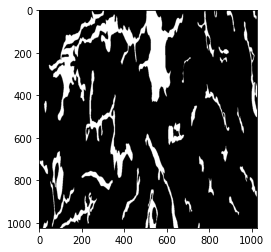

0m 3s 

Epoch 100/199
----------
epoch loss: 0.055010755608479185, acc: tensor([0.8856])
0m 2s 

Epoch 101/199
----------
epoch loss: 0.05171434556444486, acc: tensor([0.8923])
0m 2s 

Epoch 102/199
----------
epoch loss: 0.04856087292234103, acc: tensor([0.8988])
0m 2s 

Epoch 103/199
----------
epoch loss: 0.05068248634537061, acc: tensor([0.8940])
0m 2s 

Epoch 104/199
----------
epoch loss: 0.05499807943900426, acc: tensor([0.8853])
0m 2s 

Epoch 105/199
----------
epoch loss: 0.061697439104318616, acc: tensor([0.8720])
0m 2s 

Epoch 106/199
----------
epoch loss: 0.05210695664087931, acc: tensor([0.8910])
0m 2s 

Epoch 107/199
----------
epoch loss: 0.056463271379470825, acc: tensor([0.8823])
0m 2s 

Epoch 108/199
----------
epoch loss: 0.049723091224829354, acc: tensor([0.8965])
0m 2s 

Epoch 109/199
----------
epoch loss: 0.045977444077531494, acc: tensor([0.9042])
0m 2s 

Epoch 110/199
----------
epoch loss: 0.04312877555688222, acc: tensor([0.9095])
0m 2s 

Epoch 111/199
-----

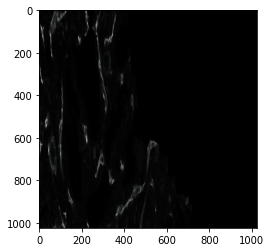

Predicted Mask Binary


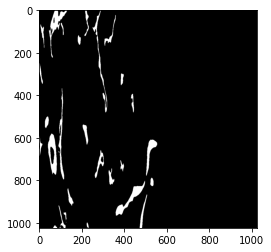

Actual Mask


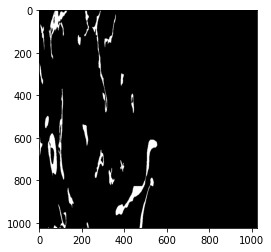

0m 3s 

Epoch 120/199
----------
epoch loss: 0.044308097163836165, acc: tensor([0.9087])
0m 2s 

Epoch 121/199
----------
epoch loss: 0.04281478350361188, acc: tensor([0.9098])
0m 2s 

Epoch 122/199
----------
epoch loss: 0.04653835644324621, acc: tensor([0.9029])
0m 2s 

Epoch 123/199
----------
epoch loss: 0.047371811543901764, acc: tensor([0.9010])
0m 2s 

Epoch 124/199
----------
epoch loss: 0.0458626555899779, acc: tensor([0.9025])
0m 2s 

Epoch 125/199
----------
epoch loss: 0.04326048816243808, acc: tensor([0.9081])
0m 2s 

Epoch 126/199
----------
epoch loss: 0.03853490489224593, acc: tensor([0.9187])
0m 2s 

Epoch 127/199
----------
epoch loss: 0.03901181183755398, acc: tensor([0.9168])
0m 2s 

Epoch 128/199
----------
epoch loss: 0.039874135454495745, acc: tensor([0.9168])
0m 2s 

Epoch 129/199
----------
epoch loss: 0.04174992789824804, acc: tensor([0.9102])
0m 2s 

Epoch 130/199
----------
epoch loss: 0.03909443902472655, acc: tensor([0.9171])
0m 2s 

Epoch 131/199
--------

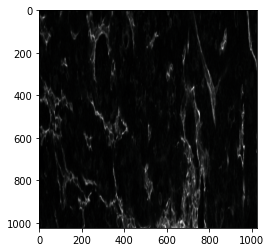

Predicted Mask Binary


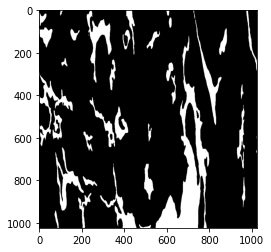

Actual Mask


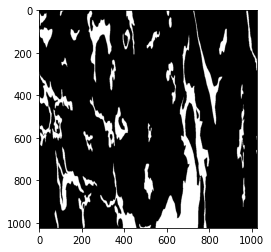

0m 3s 

Epoch 140/199
----------
epoch loss: 0.043701220055421194, acc: tensor([0.9074])
0m 2s 

Epoch 141/199
----------
epoch loss: 0.03736400194466114, acc: tensor([0.9214])
0m 2s 

Epoch 142/199
----------
epoch loss: 0.03958885706961155, acc: tensor([0.9160])
0m 2s 

Epoch 143/199
----------
epoch loss: 0.03711565397679806, acc: tensor([0.9207])
0m 2s 

Epoch 144/199
----------
epoch loss: 0.03979049436748028, acc: tensor([0.9152])
0m 2s 

Epoch 145/199
----------
epoch loss: 0.04111311646799246, acc: tensor([0.9136])
0m 2s 

Epoch 146/199
----------
epoch loss: 0.036405324439207715, acc: tensor([0.9228])
0m 2s 

Epoch 147/199
----------
epoch loss: 0.033811161294579506, acc: tensor([0.9280])
0m 2s 

Epoch 148/199
----------
epoch loss: 0.03267032826940219, acc: tensor([0.9310])
0m 2s 

Epoch 149/199
----------
epoch loss: 0.03371281599005063, acc: tensor([0.9291])
0m 2s 

Epoch 150/199
----------
epoch loss: 0.03641582280397415, acc: tensor([0.9220])
0m 2s 

Epoch 151/199
-------

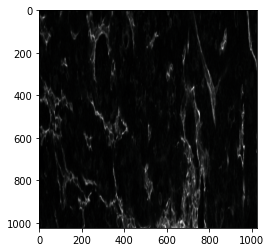

Predicted Mask Binary


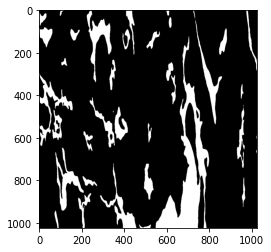

Actual Mask


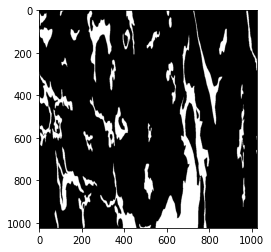

0m 3s 

Epoch 160/199
----------
epoch loss: 0.031929476434985796, acc: tensor([0.9331])
0m 2s 

Epoch 161/199
----------
epoch loss: 0.033691579351822536, acc: tensor([0.9282])
0m 2s 

Epoch 162/199
----------
epoch loss: 0.03366313626368841, acc: tensor([0.9294])
0m 2s 

Epoch 163/199
----------
epoch loss: 0.028333184371391932, acc: tensor([0.9399])
0m 2s 

Epoch 164/199
----------
epoch loss: 0.027016452451546987, acc: tensor([0.9420])
0m 2s 

Epoch 165/199
----------
epoch loss: 0.02910811218122641, acc: tensor([0.9378])
0m 2s 

Epoch 166/199
----------
epoch loss: 0.031015251328547797, acc: tensor([0.9342])
0m 2s 

Epoch 167/199
----------
epoch loss: 0.028105550756057102, acc: tensor([0.9399])
0m 2s 

Epoch 168/199
----------
epoch loss: 0.029831024631857873, acc: tensor([0.9361])
0m 2s 

Epoch 169/199
----------
epoch loss: 0.02755241816242536, acc: tensor([0.9411])
0m 2s 

Epoch 170/199
----------
epoch loss: 0.02811667857070764, acc: tensor([0.9403])
0m 2s 

Epoch 171/199
---

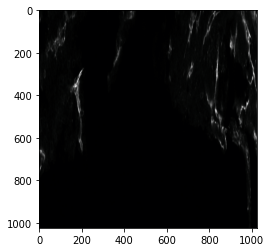

Predicted Mask Binary


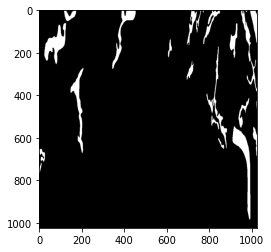

Actual Mask


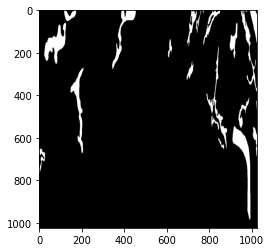

0m 3s 

Epoch 180/199
----------
epoch loss: 0.02893594615161419, acc: tensor([0.9389])
0m 2s 

Epoch 181/199
----------
epoch loss: 0.026572841281692187, acc: tensor([0.9433])
0m 2s 

Epoch 182/199
----------
epoch loss: 0.02666002164284388, acc: tensor([0.9425])
0m 2s 

Epoch 183/199
----------
epoch loss: 0.02495023546119531, acc: tensor([0.9474])
0m 2s 

Epoch 184/199
----------
epoch loss: 0.0325574304908514, acc: tensor([0.9321])
0m 2s 

Epoch 185/199
----------
epoch loss: 0.046223539113998416, acc: tensor([0.9040])
0m 2s 

Epoch 186/199
----------
epoch loss: 0.03982004498442014, acc: tensor([0.9161])
0m 2s 

Epoch 187/199
----------
epoch loss: 0.029893709595004717, acc: tensor([0.9363])
0m 2s 

Epoch 188/199
----------
epoch loss: 0.028026137873530386, acc: tensor([0.9396])
0m 2s 

Epoch 189/199
----------
epoch loss: 0.02659478907783826, acc: tensor([0.9435])
0m 2s 

Epoch 190/199
----------
epoch loss: 0.024192717174688974, acc: tensor([0.9478])
0m 2s 

Epoch 191/199
------

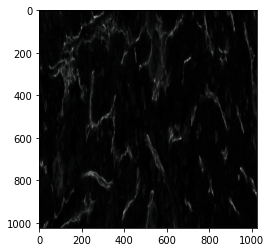

Predicted Mask Binary


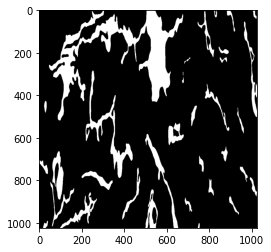

Actual Mask


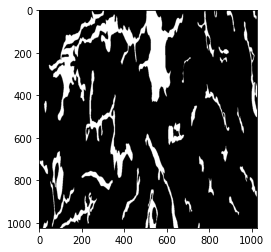

0m 3s 



In [10]:
#################
# Training Loop #
#################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1
model = ResNetUNet(num_class).to(device)

params = {
    "num_classes": num_class,
    "mdmc_average": "global",
    "average": "micro",
    "multiclass": False,
}
# accuracy = torchmetrics.Accuracy(**params).to(device)
# dice = torchmetrics.Dice(**params).to(device)

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

loss_ls, acc_ls = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=200)

In [15]:
#######################
# Test Set Dataloader #
#######################

label_path = "/home/dkermany/data/Bone_Project/final/Test/Labels/"
img_path = "/home/dkermany/data/Bone_Project/final/Test/Images/"

test_set = NucleiDataset(img_path,label_path, transform = trans)

batch_size = 1

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=1)

Input Image


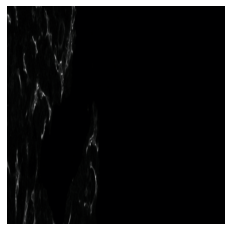

Predicted Mask Sigmoid


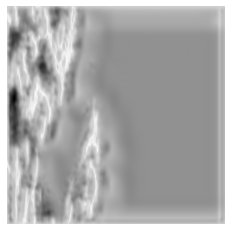

Predicted Mask Binary


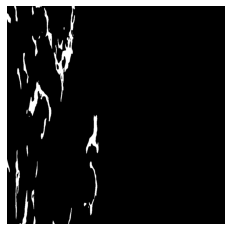

Actual Mask


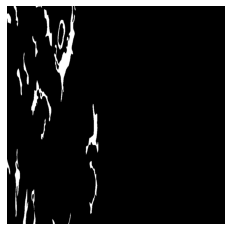

In [48]:
inputs, masks = next(iter(test_loader))
plt.axis("off")
print("Input Image")
plt.imshow(reverse_transform(inputs[0]))
plt.show()
outputs = model(inputs.to(device))
pred = outputs.to('cpu').detach().numpy()[0][0]

print("Predicted Mask Sigmoid")
plt.axis("off")
plt.imshow(pred,cmap='gray')
plt.show()
threshold=0.90    # vary the threshold
pred[pred >= threshold] = 1
pred[pred < threshold] = 0
print("Predicted Mask Binary")
plt.axis("off")
plt.imshow(pred,cmap='gray')
plt.show()
print("Actual Mask")
plt.axis("off")
plt.imshow(masks[0],cmap='gray')
plt.show()

In [45]:
def eval_model(model):
    
    loss_ls = []
    acc_ls = []
    dice_ls = []
    
    loss = 0
    acc = 0

    for inputs,masks in test_loader:
        model.eval()
        inputs = inputs.to(device)
        masks = masks.to(device).float()

        outputs = model(inputs)

        batch_loss = weighted_loss(outputs,masks,bce_weight=0.3)

        n_samples = len(inputs)
        loss+=(batch_loss/n_samples).item()

        outputs_cpu = outputs.detach().to("cpu")[0][0]
        outputs_cpu[outputs_cpu>=0.90] = 1
        outputs_cpu[outputs_cpu<0.90] = 0

        acc += iou(outputs_cpu.int(), masks.int().detach().to('cpu'))
        
        loss /= len(test_loader)
        acc /= len(test_loader)
        
        loss_ls.append(loss)
        acc_ls.append(acc)
        
    print(f"Testing Loss: {loss}, IoU: {acc}")
    return loss_ls, acc_ls

In [38]:
#################
# Eval Loop #
#################

loss_ls, acc_ls = eval_model(model)

Testing Loss: 0.1021110095359661, IoU: tensor([0.3288])
